In [13]:
import os
import sys
import math
import random
import numpy as np
import pandas as pd
from Bio.PDB import *
from Bio.PDB.Selection import unfold_entities
from Bio.PDB.NeighborSearch import NeighborSearch
import statistics as st

from sklearn.metrics import auc
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.decomposition import PCA
from sklearn import linear_model
from scipy.stats import pearsonr
from scipy.stats import spearmanr

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams.update({'font.size': 18})
import seaborn as sb
sb.set_style("whitegrid")

palette = ['#007b04', '#00d8ff', '#7bbd00',
           '#aa3fff', '#ff7f00', '#377eb8',
           '#bf2600', '#ff64f6', '#dede00']
sb.set_palette(palette=palette)

def load_resfile(file):
    res = {}
    for line in open(bsfolder+'results/'+file):
        code = line.split()[-1].split('/')[-1].split('_')[0]
        dockq = float(line.split()[1])
        if not code in res: res[code] = []
        res[code].append(dockq)
    return res

bsfolder = '/home/gabriele/Desktop/BindingSite_docking_master/'
codelist = [line.rstrip() for line in open(bsfolder+'list_dimers')]
codesb4only = [line.rstrip() for line in open(bsfolder+'b4_only')]
codesb5only = [line.rstrip() for line in open(bsfolder+'b5_only')]
chainlist = []
for code in codelist:
    chainlist.append(code+'_u1')
    chainlist.append(code+'_u2')

tags = ['BIP1', 'BIP2', 'ISP_SVM', 'ISP_CRF',
        'PRE', 'JET_CL', 'JET_TR', 'SPP']

dockqs = {'base':load_resfile('res_dockbase'),'pen':load_resfile('res_pen1'),
          'realb':load_resfile('res_dock1'), 'realu':load_resfile('res_dock1u'),
          'r02505':load_resfile('res_dock2'), 'r025075':load_resfile('res_dock3'),
          'r0505':load_resfile('res_dock4'), 'r05075':load_resfile('res_dock5'),
          'BIP1':load_resfile('res_dock6'), 'BIP2':load_resfile('res_dock7'),
          'ISP_SVM':load_resfile('res_dock8'), 'ISP_CRF':load_resfile('res_dock9'),
          'PRE':load_resfile('res_dock10'),
          'JET_CL':load_resfile('res_dock11'), 'JET_TR':load_resfile('res_dock12'),
          'SPP':load_resfile('res_dock13')}

name_refine = { 
    'realb':'Real B.S.',
    'r025075':'TPR0.25_PPV0.75',
    'r02505':'TPR0.25_PPV0.5',
    'r05075':'TPR0.5_PPV0.75',
    'r0505':'TPR0.5_PPV0.5',
    'ISP_SVM':'ISPRED4 SVM',
    'ISP_CRF':'ISPRED4 CRF',
    'BIP1':'BIPSPI 1',
    'BIP2':'BIPSPI 2',
    'PRE':'PREDUS',
    'JET_CL':'dynJET Cluster',
    'JET_TR':'dynJET Trace',
    'SPP':'SPPIder'}

In [2]:
##### DOCKING DIFFICULTY #####
def get_int(ch, opp):
    oppatoms = [atom for res in opp for atom in res]
    ns = NeighborSearch(oppatoms)
    
    intids = []
    for res in ch: 
        for atom in res:
            center = atom.get_coord()
            neighbors = ns.search(center, 10, 'R')
            if len(neighbors) != 0:
                intids.append(res.get_id()[1])
                break
    return intids

def get_contacts(strA,strB):
    contacts = []
    atomsA = [atom for res in strA for atom in res]
    atomsB = [atom for res in strB for atom in res]
    
    ns = NeighborSearch(atomsB)
    for res in strA:
        resnumA = res.get_id()[1]
        for atom in res: 
            atom = atom.get_coord()
            nlist = ns.search(atom, 5, 'R')
            for res in nlist:
                resnumB = res.get_id()[1]
                contact = str(resnumA)+'_'+str(resnumB)
                if contact not in contacts:
                    contacts.append(contact)
    
    ns = NeighborSearch(atomsA)
    for res in strB:
        nlist = []
        resnumB = res.get_id()[1]
        for atom in res: 
            atom = atom.get_coord()
            nlist = ns.search(atom, 5, 'R')
            for res in nlist:
                resnumA = res.get_id()[1]
                contact = str(resnumA)+'_'+str(resnumB)
                if contact not in contacts:
                    contacts.append(contact)
    return contacts                 

hardness = {}
h = m = e = 0
p = PDBParser(QUIET=True)
for code in codelist: 
    unbound = bsfolder+'data/processed_b4/'+code+'_uc.pdb'
    bound = bsfolder+'data/processed_b4/'+code+'_bc.pdb'
    ustr = p.get_structure('', unbound)
    bstr = p.get_structure('', bound)
    uresA = unfold_entities(ustr[0]['A'], 'R')
    uresB = unfold_entities(ustr[0]['B'], 'R')
    bresA = unfold_entities(bstr[0]['A'], 'R')
    bresB = unfold_entities(bstr[0]['B'], 'R')
    bintA = get_int(bresA, bresB)
    bintB = get_int(bresB, bresA)
    acc = 0
    for rid in bintA:
        bcarb = ucarb = ''
        if 'CA' in bstr[0]['A'][rid]:
            bcarb = bstr[0]['A'][rid]['CA']
        if 'CA' in ustr[0]['A'][rid]:
            ucarb = ustr[0]['A'][rid]['CA']
        if bcarb != '' and ucarb != '': 
            acc += (bcarb-ucarb)
        
    for rid in bintB:
        bcarb = ucarb = ''
        if 'CA' in bstr[0]['B'][rid]:
            bcarb = bstr[0]['B'][rid]['CA']
        if 'CA' in ustr[0]['B'][rid]:
            ucarb = ustr[0]['B'][rid]['CA']
        if bcarb != '' and ucarb != '':
            acc += (bcarb-ucarb)
            
    iRMSD = acc/(len(bintA)+len(bintB))
    
    if iRMSD > 2.2:
        hardness[code] = ['H', iRMSD, None]
    elif iRMSD > 1.5:
        hardness[code] = ['M', iRMSD, None]
    else:
        bresA = [bstr[0]['A'][rid] for rid in bintA]
        bresB = [bstr[0]['B'][rid] for rid in bintB]
        contb = set(get_contacts(bresA,bresB))
        uintA = get_int(uresA, uresB)
        uintB = get_int(uresB, uresA)
        uresA = [ustr[0]['A'][rid] for rid in uintA]
        uresB = [ustr[0]['B'][rid] for rid in uintB]
        contu = set(get_contacts(uresA,uresB))
        conserved = contb.intersection(contu)
        nonnat = len(contu)-len(conserved)
        F_nonnat = nonnat/len(contu)
        if F_nonnat < 0.4:
            hardness[code] = ['E', iRMSD, F_nonnat]
        else: 
            hardness[code] = ['M', iRMSD, F_nonnat]
            
h = m = e = 0
for key in hardness:
    if hardness[key][0] == 'H': h += 1
    elif hardness[key][0] == 'M': m += 1
    else: e += 1
        
print (h,m,e)
    

32 72 116


1gcq 0.19 E 0.7176956313437429
1ib1 0.152 M 0.9783174027656687
1jiw 0.18 M 1.6439300939734829
1k5g 0.201 M 1.686151736753655
1kgy 0.094 M 0.8654317472460149
1lb2 0.202 M 2.077598440647125
1lfd 0.197 E 0.8275685761752841
1nql 0.128 H 4.678465783133987
1r8s 0.147 H 3.8575027119871734
1wrd 0.11 H 2.802520609597365
1y64 0.17 H 2.7613298580198005
1y8x 0.174 H 2.372780026625032
2abz 0.165 M 0.5650721413369936
2aq3 0.085 E 0.7286070358494053
2c0l 0.202 M 1.4327655314866985
2ch4 0.098 H 6.789822783921996
2i25 0.114 M 0.5515055336903051
2ido 0.105 H 2.495995930297588
2nxn 0.089 H 12.637892898974236
2o25 0.207 M 0.8559873593190024
2uy7 0.115 H 3.0321230069828142
2vrr 0.132 M 1.5387723316423227
2xwb 0.206 H 8.86980881888156
3av0 0.224 H 2.8882505542245402
3cw2 0.012 H 9.240311685978897
3fpu 0.084 M 1.9708398642526432
3k1i 0.102 M 1.7581532156781146
3l4q 0.117 M 1.5685051715019906
3oun 0.172 M 1.192410081363561
3t5g 0.225 E 0.5570319764471302
3znz 0.122 H 16.33292000831627
4c0o 0.067 H 3.144972975

/home/gabriele/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


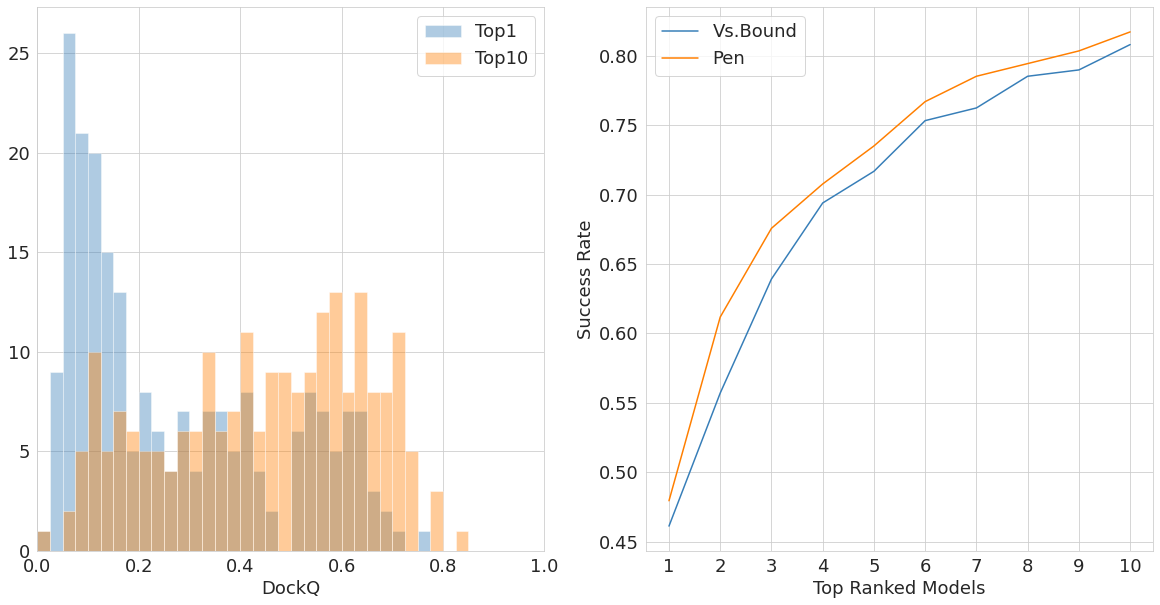

In [3]:
def get_firstmodel(key, lbl):
    results = [dockqs[key1][key][0] for key in dockqs[key1]]    
    return [results[key] for key in results]

def success_rate(runs, allowed):
    succ_rates = {'TopMod.':list(range(1,11))}
    for runkey in runs:
        for top in range(1,11):
            res = {key:max(dockqs[runkey][key][:top])\
                   for key in dockqs[runkey]\
                   if key in allowed}
            success = [1 if res[key] >= 0.23 else 0 for key in res]
            if not runkey in succ_rates: succ_rates[runkey] = []
            succ_rates[runkey].append(sum(success)/len(success))
            #if top == 10:
            #    for key in res: 
            #        if max(dockqs[runkey][key][:top]) < 0.1:
            #            print (runkey, key, dockqs[runkey][key][:top], max(dockqs[runkey][key][:top]))
                    
    succ_rates = pd.DataFrame(succ_rates)
    return succ_rates

results = [dockqs['realb'][key][0]\
           for key in dockqs['realb']]
results10 = [max(dockqs['realb'][key][:10])\
             for key in dockqs['realb']]
resultsbase = [dockqs['base'][key][0]\
               for key in dockqs['base']]

h = m = e = 0
for key in dockqs['pen']: 
    if max(dockqs['pen'][key][:10])<0.23:
        print (key, max(dockqs['pen'][key][:10]), 
               hardness[key][0], hardness[key][1])
        if hardness[key][0] == 'H': h += 1
        elif hardness[key][0] == 'M': m += 1
        else: e += 1
print (h, m, e)
#print ('Baseline avg:', round(st.mean(resultsbase),2), ' sd:',round(st.stdev(resultsbase),2))
#print ('True Top1 avg:', round(st.mean(results),2), ' sd:',round(st.stdev(results),2))
#print ('True Top10 avg:', round(st.mean(results10),2), ' sd:',round(st.stdev(results10),2))

succ_ratesbase = success_rate(['base'], codelist)
succ_ratesb = success_rate(['realb'], codelist)
succ_ratesp = success_rate(['pen'], codelist)
succ_ratesu = success_rate(['realu'], codelist)
succ_ratesb4 = success_rate(['realb'], codesb4only)
succ_ratesb5 = success_rate(['realb'], codesb5only)

#print (succ_ratesbase)
#print (succ_ratesb)
#print (succ_ratesu)
#print (succ_ratesb4)
#print (succ_ratesb5)

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
sb.distplot(results, kde=False, bins=np.arange(0.0, 1.025, 0.025), 
            color='C5', label='Top1', ax=axes[0])
sb.distplot(results10, kde=False, bins=np.arange(0.0, 1.025, 0.025), 
            color='C4', label='Top10', ax=axes[0])
axes[0].set_xlabel("DockQ")
axes[0].set_xlim(0,1)
axes[0].legend()

sb.lineplot(x='TopMod.', y='realb', data=succ_ratesb, 
            color='C5', ax=axes[1], label='Vs.Bound')
sb.lineplot(x='TopMod.', y='pen', data=succ_ratesp, 
            color='C4', ax=axes[1], label='Pen')
axes[1].set_ylabel("Success Rate")
axes[1].set_xlabel("Top Ranked Models")
axes[1].set_xticks(np.arange(1,11))

fig.savefig(bsfolder+'pictures/pyrosettavsgramm_realBS.png')
plt.show()

dqtop1 auca SpearmanrResult(correlation=0.47007168867106597, pvalue=3.3889566139407236e-73)
dqtop10 auca SpearmanrResult(correlation=0.484670867883929, pvalue=2.36230318867768e-78)
dqtop1 aucw SpearmanrResult(correlation=0.5645153950572711, pvalue=1.861434163200438e-111)
dqtop10 aucw SpearmanrResult(correlation=0.5943037243448118, pvalue=2.721223469629653e-126)


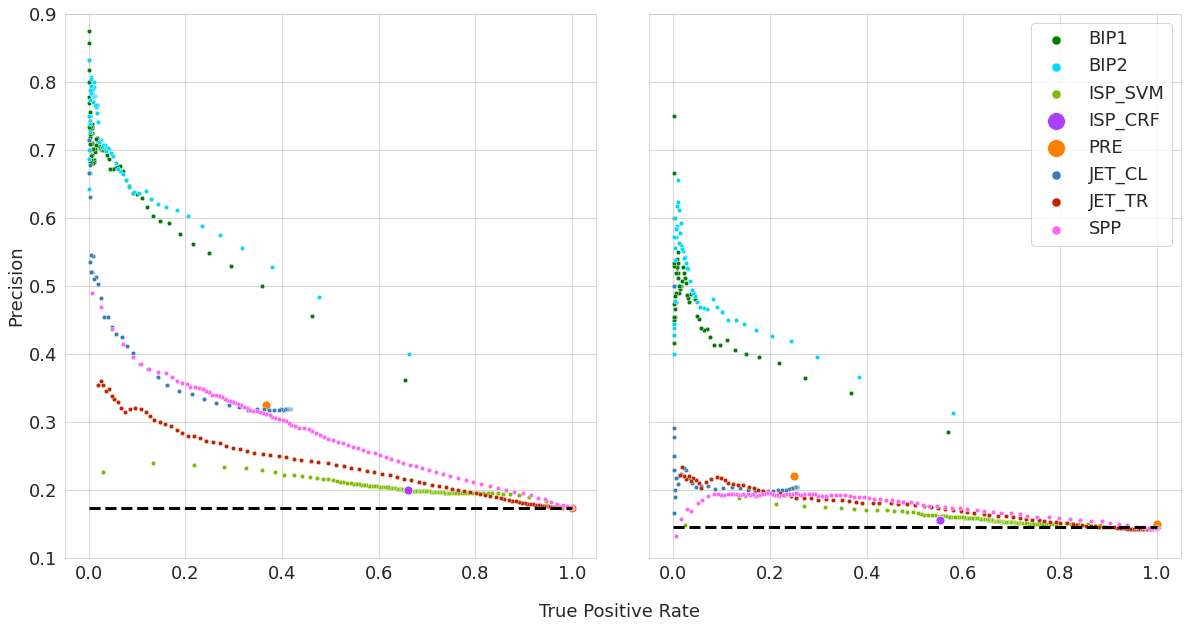

In [20]:
def get_thr(scores, thr):
    P = TP = FP = FN = TN = 0
    
    for pred, real in scores:
        if real == 1.0: P += 1
    for pred, real in scores:
        if pred >= thr:
            if real == 1.0: TP += 1
            if real == 0.0: FP += 1
        if pred < thr:
            if real == 1.0: FN += 1
            if real == 0.0: TN += 1
                
    if TP+FN != 0: TPR = TP/(TP+FN)
    else: TPR = 0.0
    if TP+FP != 0: PPV = TP/(TP+FP)
    else: PPV = 0.0
    if TPR+PPV != 0.0: F1 = 2*(TPR*PPV)/(TPR+PPV)
    else: F1 = 0.0
        
    return [TP, FP, TPR, PPV, F1]

def compute_auc_stats(scores):
    predscores = np.array(scores)
    predscores = predscores[:,0].flatten()
    realscores = np.array(scores)
    realscores = realscores[:,1].flatten()
    pPPV, pTPR, pTHR = precision_recall_curve(realscores, predscores)
    rFPR, rTPR, rTHR = roc_curve(realscores, predscores)
    stats = {'rFPR':rFPR, 'rTPR':rTPR, 'pTPR':pTPR, 'pPPV':pPPV}
    return stats
    
def BSpred_stats(n,  label):
    allscores = []
    chainscores1 = []
    chainscores2 = []
    worstscores = []

    statsmap = {}
    splitworststats = {'PPV':[], 'TPR':[]}
    for code in chainlist:
        pdbcode = code[:4]
        labelfile = bsfolder+'data/formatted_labels/'+code+'.site'
        if not os.path.exists(labelfile): 
            print (labelfile, 'not found!')
            continue
        isp = [float(line.split()[n]) if line.split()[n] != '1.0'
               else 0.99 for line in open(labelfile)]
        ist = [float(line.split()[1]) for line in open(labelfile)]
        rsa = [float(line.split()[0]) for line in open(labelfile)]
        for lp, lt, acc in zip(isp, ist, rsa):
            if acc < 0.2: continue
            allscores.append([lp, lt])
            if '_u1' in code: chainscores1.append([lp, lt])
            else: chainscores2.append([lp, lt])

        if '_u2' in code:
            stats1 = compute_auc_stats(chainscores1)
            stats2 = compute_auc_stats(chainscores2)
            statsd = compute_auc_stats(chainscores1+chainscores2)
            auc1 = auc(stats1['pTPR'], stats1['pPPV'])
            auc2 = auc(stats2['pTPR'], stats2['pPPV'])
            aucd = auc(statsd['pTPR'], statsd['pPPV'])
            
            statsmap[pdbcode] = {}
            statsmap[pdbcode]['PR-AUC'] = [auc1, auc2, aucd]
            
            if auc1 < auc2: worstscores += chainscores1
            else: worstscores += chainscores2
            chainscores1 = []
            chainscores2 = []           
    
    allstats = compute_auc_stats(allscores)
    worststats = compute_auc_stats(worstscores)
    return allstats, worststats, statsmap

metricdic = {}
for n, tag in enumerate(tags):
    allstats, worststats, mapping = BSpred_stats(n+6, tag)
    metricdic[tag+'all'] = allstats
    metricdic[tag+'worst'] = worststats
    metricdic[tag+'map'] = mapping
    
    #prauc = auc(allpart['pTPR'], allpart['pPPV'])
    #wprauc = auc(worstpart['pTPR'], worstpart['pPPV'])
    #print (tag, allpart['pTPR'], allpart['pPPV'])
    #print (worstpart['pTPR'], worstpart['pPPV'], round(prauc,2), round(wprauc,2))

data = {'dqtop1':[], 'dqtop10':[],
        'auca':[], 'aucw':[]}
for tag in tags:
    if 'BIP' in tag: continue
    tagmap = tag+'map'
    for pdb in codelist:
        if not pdb in dockqs[tag]: continue
        if not pdb in metricdic[tagmap]: continue
        data['dqtop1'].append(dockqs[tag][pdb][0])
        data['dqtop10'].append(max(dockqs[tag][pdb]))
        data['auca'].append(metricdic[tagmap][pdb]['PR-AUC'][2])
        data['aucw'].append(min(metricdic[tagmap][pdb]['PR-AUC'][:2]))
    
print ('dqtop1', 'auca', spearmanr(data['dqtop1'], data['auca']))
print ('dqtop10', 'auca', spearmanr(data['dqtop10'], data['auca']))
print ('dqtop1', 'aucw', spearmanr(data['dqtop1'], data['aucw']))
print ('dqtop10', 'aucw', spearmanr(data['dqtop10'], data['aucw']))

fig, axes = plt.subplots(1, 2, figsize=(20, 10), 
                         sharex=True, sharey=True)

for n, tag in enumerate(tags):
    if tag == 'ISP_CRF' or tag == 'PRE': s = 80
    else: s = 20
    sb.scatterplot(x='pTPR', y='pPPV', data=metricdic[tag+'all'],
                   color='C'+str(n), s=s, label=tag, ax=axes[0])    
    sb.scatterplot(x='pTPR', y='pPPV', data=metricdic[tag+'worst'],
                   color='C'+str(n), s=s, label=tag, ax=axes[1])
 
axes[0].legend(markerscale=2)
axes[1].legend(markerscale=2)
axes[0].set_ylabel('Precision')
axes[0].set_xlabel('')
axes[1].set_xlabel('')
fig.text(0.51, 0.05, 'True Positive Rate', ha='center', va='center')
axes[1].set_ylim(0.1,0.9)
axes[0].plot([0, 1], [metricdic['BIP1all']['pPPV'][0],
                metricdic['BIP1all']['pPPV'][0]],
                ls="--", lw='3', color='black')
axes[1].plot([0, 1], [metricdic['BIP1worst']['pPPV'][0],
                metricdic['BIP1worst']['pPPV'][0]],
                ls="--", lw='3', color='black')
axes[0].get_legend().remove()
plt.subplots_adjust(wspace=0.1)

fig.savefig(bsfolder+'pictures/PRcurve.png')

# 1 - PR-curve, whole dataset
# 2 - PR curve, worst-predicted-interface partner in each dimer

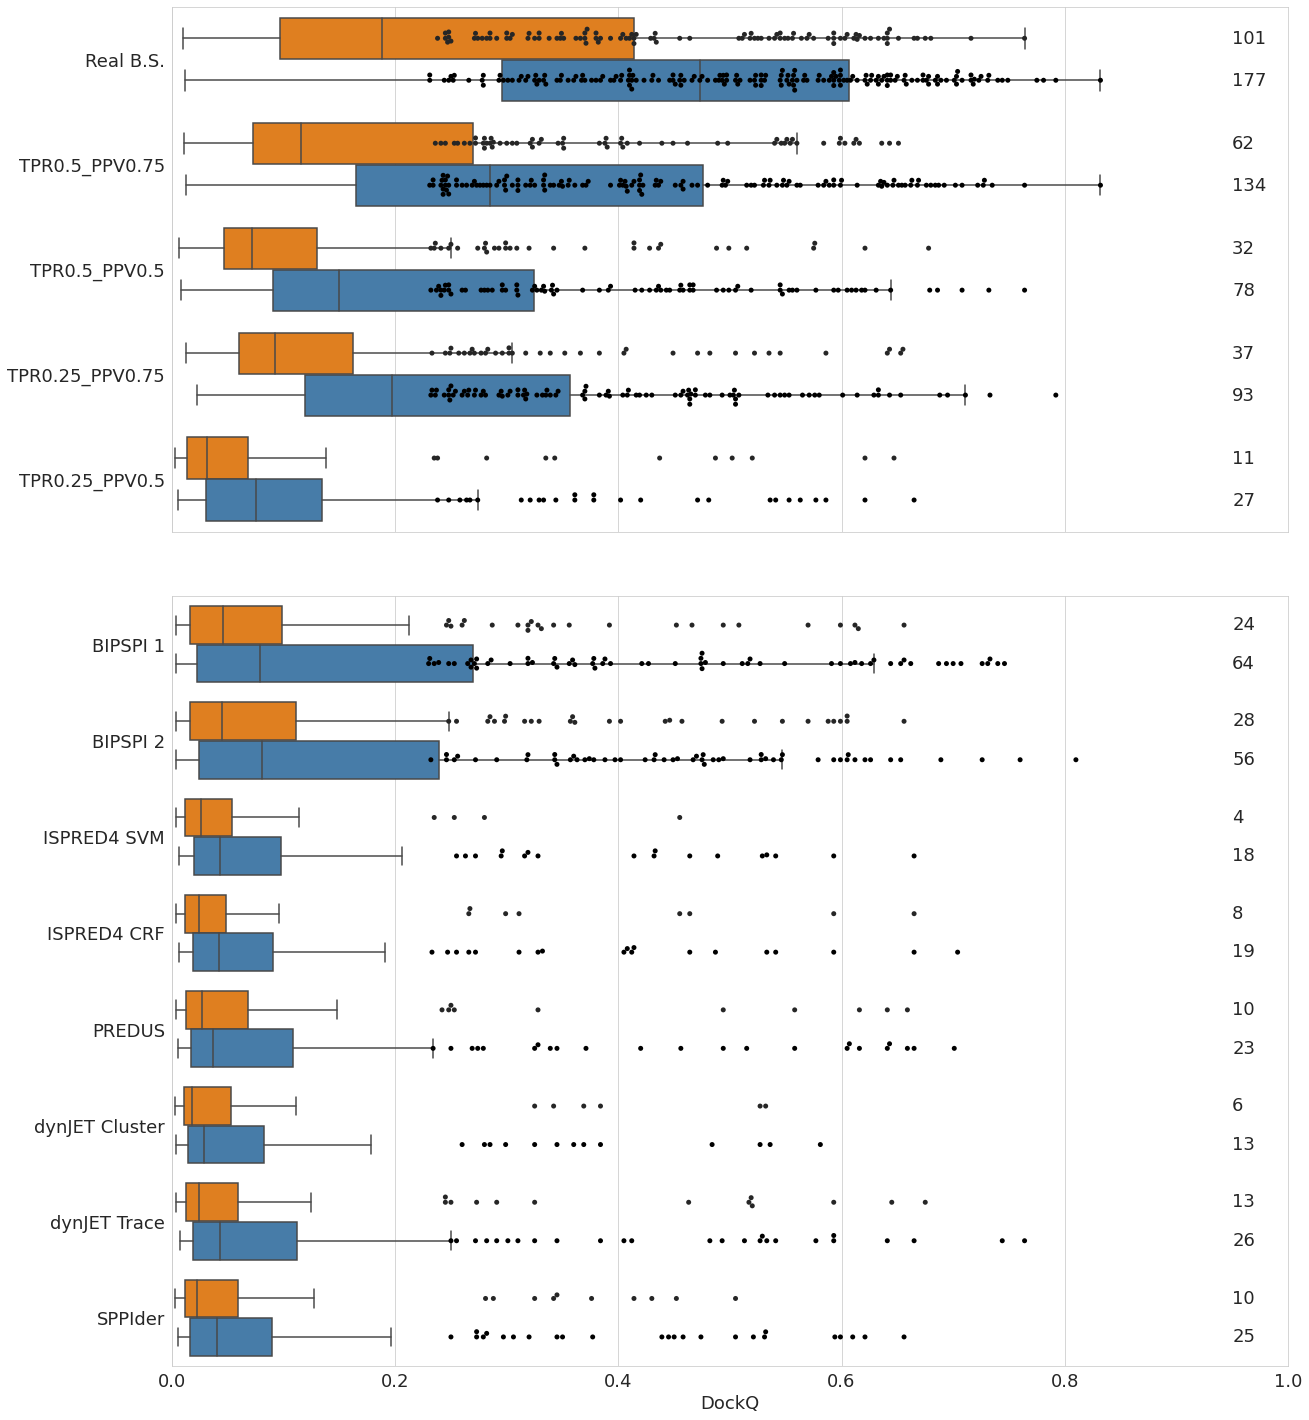

In [7]:
def compare_runs(runs, top1=True):
    countdic = []
    bardic = {'DockQ':[], 'Setup':[], 'Top':[]}
    swarmdic = {'DockQ':[], 'Setup':[], 'Top':[]}
    for run in runs:
        top1dq = [dockqs[run][code][0] for code in dockqs[run]]
        top10dq = [max(dockqs[run][code][:10]) for code in dockqs[run]]
        #print (run, 'top1 avg:', round(st.mean(top1dq),2), round(st.stdev(top1dq),2))
        #print (run, 'top10 avg:', round(st.mean(top10dq),2), round(st.stdev(top10dq),2))
        countdic.append(len([1 for code in dockqs[run]\
                             if dockqs[run][code][0] >= 0.23]))
        countdic.append(len([1 for code in dockqs[run]\
                             if max(dockqs[run][code]) >= 0.23]))
        for code in dockqs[run]:
            bardic['DockQ'].append(dockqs[run][code][0])
            bardic['Setup'].append(name_refine[run])
            bardic['Top'].append('Top1')
            bardic['DockQ'].append(max(dockqs[run][code]))
            bardic['Setup'].append(name_refine[run])
            bardic['Top'].append('Top10')
            if dockqs[run][code][0] >= 0.23:
                swarmdic['DockQ'].append(dockqs[run][code][0])
                swarmdic['Setup'].append(name_refine[run])
                swarmdic['Top'].append('Top1')
            if max(dockqs[run][code]) >= 0.23:
                swarmdic['DockQ'].append(max(dockqs[run][code]))
                swarmdic['Setup'].append(name_refine[run])
                swarmdic['Top'].append('Top10')
        if not name_refine[run] in swarmdic['Setup']:
            swarmdic['DockQ'].append(-1)
            swarmdic['Setup'].append(name_refine[run])
            swarmdic['Top'].append('Top1')
            swarmdic['DockQ'].append(-1)
            swarmdic['Setup'].append(name_refine[run])
            swarmdic['Top'].append('Top10')
    return bardic, swarmdic, countdic

def plot_rungroups(runs, axes):
    
    bardic, swarmdic, countdic = compare_runs(runs)
    
    hue_order = ['Top1', 'Top10']
    palette = {top:'C4' if top=='Top1' else 'C5' for top in set(bardic['Top'])}
    horder = []
    sb.swarmplot(x='DockQ', y='Setup', hue='Top', data=swarmdic, color='Black', 
                 dodge=True, size=5, hue_order=hue_order, ax=axes)
    sb.boxplot(x='DockQ', y='Setup', hue='Top', data=bardic, 
               palette=palette, showfliers=False, 
               hue_order=hue_order, ax=axes)
    axes.get_legend().remove()
    for n, count in enumerate(countdic):
        if n%2 != 0: mod = 0.25
        else: mod = -0.15
        if n%2 != 0: n -= 1
        n /= 2
        axes.text(x=0.95, y=n+mod, s=count)
    axes.set_xticks(np.arange(0, 1.1, 0.2))


fig, axes = plt.subplots(2, 1, figsize=(20, 25), sharex=True,
                         gridspec_kw={'height_ratios': [15, 22]})
plt.subplots_adjust(hspace=0.1)

runs = ['realb', 'r05075', 'r0505', 'r025075', 'r02505']
plot_rungroups(runs, axes[0])

runs = ['BIP1', 'BIP2', 'ISP_SVM', 'ISP_CRF', 
        'PRE', 'JET_CL', 'JET_TR', 'SPP']
plot_rungroups(runs, axes[1])
axes[1].set_xlim(0,1)
axes[1].set_xlabel('DockQ')
fig.savefig(bsfolder+'pictures/DockQs.png')

In [159]:
def dist(a, b):
    dist = math.sqrt(sum([(ac-bc)**2 for ac, bc in zip(a,b)]))
    return dist

cidev = {}
p = PDBParser(QUIET=True)
for code in chainlist: 
    pdb = code.split('_')[0]
    struc = p.get_structure('', bsfolder+'data/processed_b4/'+code+'.pdb')
    reslist = unfold_entities(struc[0], 'R')
    scorelist = [[float(el) for el in line.split()]\
                 for line in open(bsfolder+'data/formatted_labels/'+code+'.site')]
    if len(reslist) != len(scorelist): 
        print (code,'str len != scores len')
        continue
    
    for tag in tags:
        tag += 'map'
        count = 0
        totmass = 0.0
        surfmass = 0.0
        surfci = [0.0,0.0,0.0]
        trueci = [0.0,0.0,0.0]
        predci = [0.0,0.0,0.0]
        for res, sl in zip(reslist, scorelist):
            try: atom = res['CB'].get_coord()
            except: pass
            try: atom = res['CA'].get_coord()
            except: pass
            try: atom = res['C'].get_coord()
            except: continue
            if sl[0] >= 0.2 and sl[1] == 1.0:
                for n in range(3): predci[n] += atom[n]*sl[8]
                for n in range(3): trueci[n] += atom[n]
                totmass += sl[8]
                count += 1
            if sl[0] >= 0.2:
                for n in range(3): surfci[n] += atom[n]*sl[8]
                surfmass += sl[8]
        for n, coord in enumerate(surfci): surfci[n] = coord/surfmass
        for n, coord in enumerate(predci): predci[n] = coord/totmass
        for n, coord in enumerate(trueci): trueci[n] = coord/count
        metricdic[tag][pdb]['cdist'] = [dist(trueci, predci),
                                        dist(trueci, surfci),
                                        dist(predci, surfci)]


In [160]:
def getAngle(a, b):
    at1 = math.atan2(b[1], b[0])
    at2 = math.atan2(a[1], a[0])
    ang = math.degrees(at2 - at1)
    return ang + 360 if ang < 0 else ang


pdbvec = {}
p = PDBParser(QUIET=True)
for code in chainlist:
    pdb = code.split('_')[0]
    struc = p.get_structure('', bsfolder+'data/processed_b4/'+code+'.pdb')
    reslist = unfold_entities(struc[0], 'R')
    scorelist = [[float(el) for el in line.split()]\
                 for line in open(bsfolder+'data/formatted_labels/'+code+'.site')]
    if len(reslist) != len(scorelist): 
        print (code,'str len != scores len')
        continue
        
    for n, tag in enumerate(tags):
        true = []
        pred = []
        coords = []
        icoords = []
        for res, sl in zip(reslist, scorelist):
            try: atom = res['CB'].get_coord()
            except: pass
            try: atom = res['CA'].get_coord()
            except: pass
            try: atom = res['C'].get_coord()
            except: continue
            if sl[0] >= 0.2:
                true.append(sl[1])
                pred.append(sl[n+6])
                if sl[1] == 1.0: icoords.append(atom) 
                coords.append(atom)    

        true = np.array(true)
        pred = np.array(pred)
        coords = np.array(coords)
        icoords = np.array(icoords)
        
        icm = np.sum(icoords, axis=0)/len(icoords)
        coords = coords-icm
        result = np.sum(coords*np.expand_dims(pred, axis=-1), axis=0)
        result_len = math.sqrt(np.sum(result**2))
        
        if not 'Vec.Res' in metricdic[tag+'map'][pdb]:
            metricdic[tag+'map'][pdb]['Vec.Res'] = [result_len]
        else:
            metricdic[tag+'map'][pdb]['Vec.Res'].append(result_len)
        
#### do same for vec wholeres.cm->trueinterfaceresultant and 
#### wholeres.cm->allpredictionresultant

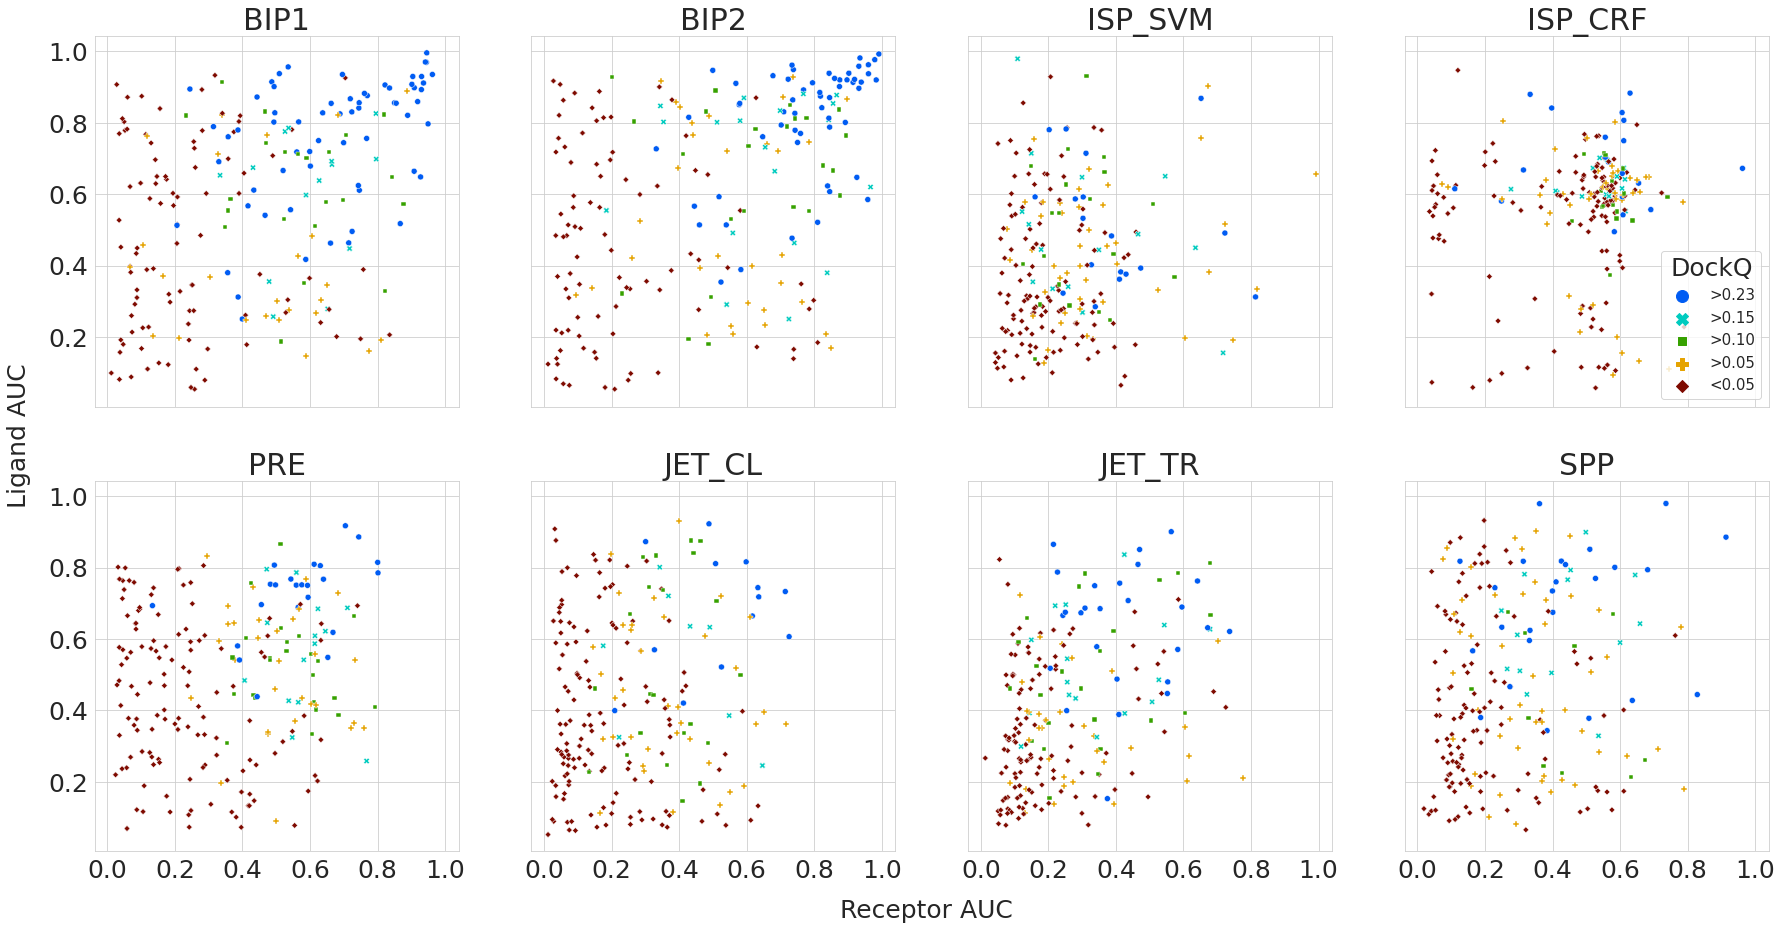

In [275]:
weirdos = {}
data = {'P1':[], 'P2':[], 'DockQ':[], 'Method':[]}

for tag in tags:
    weirdos[tag] = {}
    maptag = tag + 'map'
    for pdb in codelist:
        if not pdb in dockqs[tag]: continue
        if not pdb in metricdic[maptag]: continue
        data['P1'].append(metricdic[maptag][pdb]['PR-AUC'][0])
        data['P2'].append(metricdic[maptag][pdb]['PR-AUC'][1])        
        data['Method'].append(tag)
        dockQ = max(dockqs[tag][pdb][:10])
        if dockQ >= 0.23: data['DockQ'].append('>0.23')
        elif dockQ >= 0.15: data['DockQ'].append('>0.15')
        elif dockQ >= 0.10: data['DockQ'].append('>0.10')
        elif dockQ >= 0.05: data['DockQ'].append('>0.05')
        else: data['DockQ'].append('<0.05')
            
        if data['P1'][-1] >= 0.4 and data['P2'][-1] >= 0.4: 
            weirdos[tag][pdb] = [dockQ]+metricdic[maptag][pdb]['PR-AUC']                                    

data = pd.DataFrame(data)
palette = ['#005cf3', '#00cbbf', '#36a100',
           '#e5a300', '#7e0a00']
sb.set_palette(palette=palette)
fig, axes = plt.subplots(2, 4, figsize=(30, 15), 
                         sharex=True, sharey=True)

suby = len(set(data['Method']))
for py in range(suby):
    method = tags[py]
    subdata = data.loc[data['Method'] == method]
    if py < 4: 
        px = 0
    else:
        py -= 4
        px = 1 
    axes[px][py].title.set_text(method)
    splot = sb.scatterplot(x='P1', y='P2', 
                            hue='DockQ', style='DockQ',
                            data=subdata,
                            hue_order=['>0.23','>0.15',
                                        '>0.10','>0.05',
                                        '<0.05'],
                            style_order=['>0.23','>0.15',
                                        '>0.10','>0.05',
                                        '<0.05'],
                            ax=axes[px][py])
    if not(py == 3 and px==0): 
        axes[px][py].legend([],[], frameon=False)
    else: 
        axes[px][py].legend(loc='lower right', title='DockQ', 
                            markerscale=2, prop={'size': 15})
        
    axes[px][py].set_xlabel('')
    axes[px][py].set_ylabel('')
plt.xticks(np.arange(0,1.2,0.2))
fig.text(0.51, 0.07, 'Receptor AUC', ha='center', va='center')
fig.text(0.09, 0.51, 'Ligand AUC', ha='center', va='center', rotation=90)
fig.savefig(bsfolder+'pictures/DockQxAUC.png')
plt.show()


In [279]:
maxb = 
minb = 
for method in weirdos:
    for code in weirdos[method]:
        if weirdos[method][code][0] < 0.23:
            print(method, code, weirdos[method][code])

commons = set()
for method in weirdos:
    newset = set(weirdos[method].keys())
    if len(commons) == 0: commons = newset
    else: commons = commons.intersection(newset)        
        
print ('COMMONS')
for code in commons:
    for method in weirdos:
        print (code, method, weirdos[method][code])

BIP1 1fle [0.124, 0.8182857712462976, 0.8238095238095238]
BIP1 1gg2 [0.22, 0.5879761904761904, 0.5978592542326095]
BIP1 1i2m [0.127, 0.8767504376094022, 0.5736179632781011]
BIP1 1jk9 [0.094, 0.8879106457846617, 0.8890285326086957]
BIP1 1k5g [0.106, 0.8430619491742961, 0.6491486150784931]
BIP1 1lfd [0.228, 0.7958003984319773, 0.6985906566551727]
BIP1 1nw9 [0.04, 0.40446345852524346, 0.6590221847576248]
BIP1 1s1q [0.124, 0.6156612069995222, 0.5114699653446284]
BIP1 1vg0 [0.111, 0.5643245681514002, 0.7129965160625537]
BIP1 1xt9 [0.022, 0.7043484443731619, 0.9260080395794681]
BIP1 1z5y [0.21, 0.7949620678138556, 0.826299009632343]
BIP1 2abz [0.174, 0.7169065275682924, 0.44794687366914904]
BIP1 2aq3 [0.08, 0.6063221765511841, 0.48256854256854254]
BIP1 2ido [0.105, 0.6461988243238243, 0.5780340379457416]
BIP1 2nxn [0.048, 0.48953555505707824, 0.7081425987675987]
BIP1 2o8v [0.111, 0.5223015873015873, 0.5302982405366697]
BIP1 2uy7 [0.064, 0.6815440697381094, 0.821890018012187]
BIP1 2x0b [0.038